# Example: Single Asset Geometric Brownian Motion (GBM) Models
In this example, we will estimate the parameters of a geometric Brownian motion (GBM) model for a single asset, and then use this model to simulate future price paths.

> __Learning Objectives:__
>
> * **Estimate GBM parameters using linear regression and maximum likelihood methods.** We implement drift parameter estimation through linear regression on log prices and volatility estimation using maximum likelihood fitting of return distributions.
> * **Validate parameter estimates through statistical testing and confidence intervals.** We assess model assumptions using Anderson-Darling tests for normality and compute confidence intervals to quantify uncertainty in parameter estimates.
> * **Simulate and evaluate GBM model performance against real market data.** We generate sample price trajectories and compare model predictions with actual stock prices to assess the model's effectiveness for forecasting.

This is going to be interesting, so let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

>__Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, and configures the environment. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [3]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

### Data
We gathered daily open-high-low-close (OHLC) data for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2014` until `12-31-2024`, along with data for several exchange-traded funds and volatility products during that time period. 

Let's load the `original_dataset::DataFrame` by calling [the `MyTrainingMarketDataSet()` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyTrainingMarketDataSet) and remove firms that do not have the maximum number of trading days. The cleaned dataset $\mathcal{D}$ will be stored in the `dataset` variable.

In [6]:
original_dataset = MyTrainingMarketDataSet() |> x-> x["dataset"];

Not all tickers in our dataset have the maximum number of trading days for various reasons, such as acquisition or delisting events. Let's collect only those tickers with the maximum number of trading days.

First, let's compute the number of records for a firm that we know has the maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days::Int64` variable:

In [8]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [10]:
dataset = let

    # initialize -
    dataset = Dict{String, DataFrame}();

    # iterate through the dictionary; we can't guarantee a particular order
    for (ticker, data) ∈ original_dataset  # we get each (K, V) pair!
        if (nrow(data) == maximum_number_trading_days) # check if ticker has maximum trading days
            dataset[ticker] = data;
        end
    end
    dataset; # return
end;

Finally, let's get a list of the firms in our cleaned dataset and sort them alphabetically. We store the sorted firm ticker symbols in the `list_of_tickers::Array{String,1}` variable:

In [12]:
list_of_tickers = keys(dataset) |> collect |> sort; # list of firm "ticker" symbols in alphabetical order

### Constants
Finally, let's set some constants we'll use later in this notebook. The comments describe the constants, their units, and permissible values:

In [14]:
Δt = (1.0/252.0); # time step
T = 64; # length of simulation -> 1 trading quarter
all_range = range(1,stop=maximum_number_trading_days,step=1) |> collect;

___

## Task 1: Estimate the $\mu$ parameter from data
In this task, we will estimate the drift parameter $\mu$ from historical price data. Given the price observations ${S_{1},\ldots,S_{N}}$, we can construct an __overdetermined__ system of equations:
$$
\begin{align*}
\hat{\mathbf{X}}\mathbf{\theta} + \epsilon &= \mathbf{y}\\
\end{align*}
$$
where $\mathbf{\theta}$ is the parameter vector we want to estimate (the y-intercept $\ln(S_{0})$ and slope $m = \mu$), $\epsilon\sim\mathcal{N}(0,\sigma_{\epsilon}^{2})$ is an error model, $\mathbf{X}$ is the $N\times{2}$ design matrix, and $\mathbf{y}$ is the $N\times{1}$ observation vector. The design matrix $\mathbf{X}$ is given by:
$$
\begin{align*}
\hat{\mathbf{X}} &= \begin{bmatrix}
1 & 1\Delta{t} \\
1 & 2\Delta{t} \\
\vdots & \vdots \\
1 & N\Delta{t}
\end{bmatrix}\\
\end{align*}
$$
while the observation vector $\mathbf{y}$ is given by:
$$
\begin{align*}
\mathbf{y} &= \begin{bmatrix}
\ln(S_{1}) \\
\ln(S_{2}) \\
\vdots \\
\ln(S_{N})
\end{bmatrix}\\
\end{align*}
$$
The unknown (expected) parameter vector estimate $\hat{\mathbf{\theta}}$ has an analytical solution given by the normal equations:
$$
\boxed{
\begin{align*}
\hat{\mathbf{\theta}} &= (\hat{\mathbf{X}}^{\top}\hat{\mathbf{X}})^{-1}\hat{\mathbf{X}}^{\top}\mathbf{y}\quad\blacksquare\\
\end{align*}}
$$


In [91]:
θ̂_dictionary = let

    # initialize -
    data = Dict{String, NamedTuple}();

    for ticker ∈ eachindex(list_of_tickers)
        firm_ticker = list_of_tickers[ticker];
        firm_data = dataset[firm_ticker];
        T_all = all_range*Δt .- Δt;

        A = [ones(maximum_number_trading_days) T_all];
        Y = log.(firm_data[!,:volume_weighted_average_price]);

        # Solve the normal equations
        θ = inv(transpose(A)*A)*transpose(A)*Y;

        # store the results in a named tuple -
        data[firm_ticker] = (b = θ[1], m = θ[2]);
    end
    data; # return
end

Dict{String, NamedTuple} with 424 entries:
  "EMR"  => (b = 3.92437, m = 0.0644198)
  "CTAS" => (b = 2.69144, m = 0.235649)
  "HSIC" => (b = 3.95725, m = 0.0386116)
  "KIM"  => (b = 3.12273, m = -0.0208058)
  "PLD"  => (b = 3.60571, m = 0.132629)
  "IEX"  => (b = 4.2588, m = 0.123906)
  "BAC"  => (b = 2.75484, m = 0.0930762)
  "CBOE" => (b = 4.0031, m = 0.107147)
  "EXR"  => (b = 4.0407, m = 0.109955)
  "NCLH" => (b = 4.107, m = -0.119297)
  "CVS"  => (b = 4.45628, m = -0.0196272)
  "DRI"  => (b = 3.97448, m = 0.111374)
  "DTE"  => (b = 4.42641, m = 0.0416772)
  "ZION" => (b = 3.42861, m = 0.0486871)
  "AVY"  => (b = 3.90957, m = 0.148483)
  "EW"   => (b = 2.98773, m = 0.171359)
  "EA"   => (b = 3.95994, m = 0.111369)
  "NWSA" => (b = 2.51942, m = 0.0508625)
  "CAG"  => (b = 3.6385, m = -0.0186004)
  "GILD" => (b = 4.47077, m = -0.0246717)
  "FCX"  => (b = 2.4883, m = 0.100435)
  "GPC"  => (b = 4.37165, m = 0.0563871)
  "UNP"  => (b = 4.54326, m = 0.0928863)
  "CDW"  => (b = 3.36536, m

### Check: Is the actual residual normally distributed?
We assumed that the error model `ϵₙ`, which describes the portion of the data not captured by the deterministic share price expression, was normally distributed. Let's plot the actual density `ϵ` of the residuals and a normal error model to see how well they match:

In [97]:
 ϵ, ϵₙ, rand_firm_ticker, A, Y = let
    rand_firm_ticker = rand(list_of_tickers)
    firm_data = dataset[rand_firm_ticker]
    T_all = all_range*Δt .- Δt;
    A = [ones(maximum_number_trading_days) T_all];
    Y = log.(firm_data[!,:volume_weighted_average_price]);
    
    θ = [
        θ̂_dictionary[rand_firm_ticker].b, # intercept
        θ̂_dictionary[rand_firm_ticker].m # slope
    ];

    ϵ = Y .- A*θ
    ϵₙ = fit_mle(Normal,ϵ);

    (ϵ, ϵₙ, rand_firm_ticker, A, Y); # return
end;

The plot shows the comparison between the fitted normal distribution and the actual residual distribution. We can observe how well the normal assumption holds for our error model.

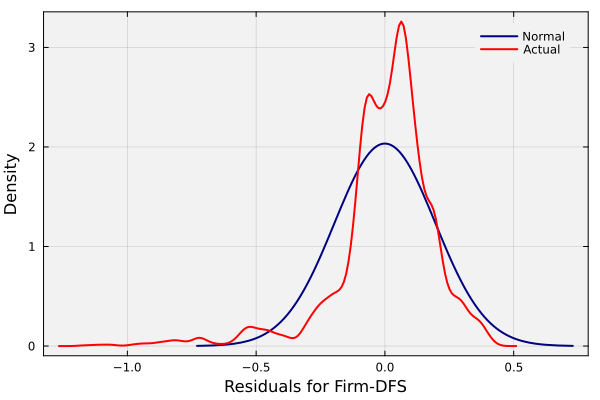

In [99]:
let 
    
    plot(ϵₙ, label="Normal", c=:navyblue,lw=2)
    density!(ϵ, normalize=true, xlabel="Residuals for Firm-$(rand_firm_ticker)", 
        ylabel="Density", label="Actual", c=:red,lw=2)

    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);

end

#### Anderson-Darling Test

Let's examine the AD test results for the residuals of the ticker specified in the `rand_firm_ticker::String` variable. What is an AD test?

> __Anderson–Darling test:__ The Anderson–Darling (AD) test is a statistical test of whether a given sample of data is drawn from a specified probability distribution. It is a type of goodness-of-fit test that compares the empirical cumulative distribution function of the sample data to the cumulative distribution function of the specified distribution. The AD test is particularly sensitive to differences in the tails of the distributions, making it useful for detecting deviations from the assumed distribution in those regions.

> __Null hypothesis:__ The Anderson–Darling test examines the null hypothesis that the data in vector $x$ come from the distribution $d$ against the alternative hypothesis that the sample is not drawn from $d$. This test reports a p-value, the probability that, assuming the null hypothesis is true (your data really are i.i.d. from $d$), the AD test statistic would be at least as extreme as the one computed from your data. 

> __TLDR:__ A small p-value or large $A^{2}$ statistic indicates that the null hypothesis is unlikely to be true, i.e., the data is unlikely to be drawn from the specified distribution $d$.

Let's perform a one-sample [Anderson–Darling test](https://en.wikipedia.org/wiki/Anderson–Darling_test), exported by the [HypothesisTests.jl package](https://juliastats.org/HypothesisTests.jl/stable/), of the `H0: null hypothesis` that the actual residual `ϵ` is drawn from the distribution `ϵₙ` against the `H1: alternative hypothesis` that the sample is not drawn from distribution `ϵ`.

In [101]:
AD_test_result = OneSampleADTest(ϵ,ϵₙ)

One sample Anderson-Darling test
--------------------------------
Population details:
    parameter of interest:   not implemented yet
    value under h_0:         NaN
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: reject h_0
    one-sided p-value:           <1e-06

Details:
    number of observations:   2767
    sample mean:              3.105896056746806e-15
    sample SD:                0.1961592596876471
    A² statistic:             73.57274866785484


### Check: How well does the deterministic model describe the VWAP trajectory?
Before we estimate the volatility parameter $\sigma$, let's examine how well the VWAP is replicated using only the deterministic portion of the GBM model and how uncertainty in $\mu$ influences the simulation.

> __Sampling:__ Let's compute the predicted share price $\hat{\mathbf{Y}}$ where we sample the error model $\epsilon_{n}$ to compute possible values for $\theta$, and then compute the share price values. We store the predicted share prices in the `error_simulation_array` variable.

What do we observe?

In [103]:
error_simulation_array = let
    N = 1000;
    
    error_simulation_array = Array{Float64,2}(undef,maximum_number_trading_days,N);
    for i ∈ 1:N
        error = rand(ϵₙ,maximum_number_trading_days)
        θᵢ = inv(transpose(A)*A)*transpose(A)*Y + inv(transpose(A)*A)*transpose(A)*error
        Ŷᵢ = A*θᵢ
        for k ∈ 1:maximum_number_trading_days
            error_simulation_array[k,i] =  Ŷᵢ[k]
        end
    end

    error_simulation_array;
end

2767×1000 Matrix{Float64}:
 3.90293  3.89571  3.91576  3.90523  …  3.91551  3.90007  3.92412  3.90858
 3.90325  3.89603  3.91608  3.90556     3.91583  3.9004   3.92444  3.9089
 3.90358  3.89636  3.9164   3.90589     3.91615  3.90073  3.92475  3.90922
 3.90391  3.89669  3.91673  3.90622     3.91647  3.90106  3.92507  3.90955
 3.90424  3.89702  3.91705  3.90655     3.91679  3.90139  3.92538  3.90987
 3.90456  3.89734  3.91738  3.90688  …  3.91711  3.90172  3.9257   3.9102
 3.90489  3.89767  3.9177   3.90721     3.91743  3.90205  3.92601  3.91052
 3.90522  3.898    3.91803  3.90754     3.91775  3.90238  3.92633  3.91085
 3.90554  3.89832  3.91835  3.90786     3.91807  3.90271  3.92664  3.91117
 3.90587  3.89865  3.91867  3.90819     3.91839  3.90304  3.92696  3.9115
 3.9062   3.89898  3.919    3.90852  …  3.91871  3.90338  3.92727  3.91182
 3.90653  3.89931  3.91932  3.90885     3.91903  3.90371  3.92759  3.91214
 3.90685  3.89963  3.91965  3.90918     3.91935  3.90404  3.9279   3.91247
 

`Unhide` the code block below to see how we compute and plot the expected value and the uncertainty $\hat{\sigma}$ of the expected value of the VWAP. We plot $\pm~{3.291}\cdot\hat{\sigma}$ in `gray` (the `99.9%` confidence interval) around the expected deterministic VWAP value $\mu$ shown in `red`.

> __Summary:__ The deterministic price model parameterized with the growth rate $\mu$ tracks the central trend of the VWAP. However, the deterministic model does not describe the random fluctuations observed around the price. 

To account for the randomness, we must include the model's random component, which requires estimating the volatility parameter $\sigma$, which modifies the noise term.

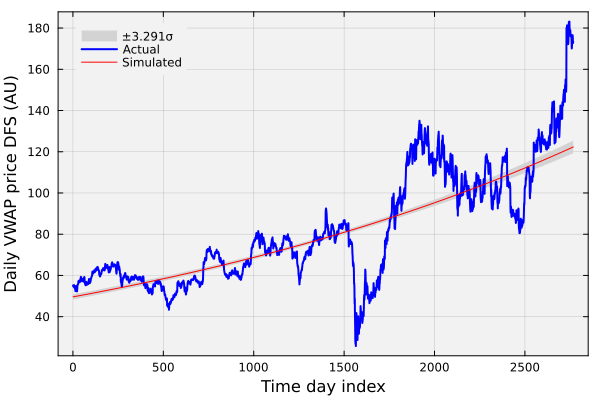

In [105]:
let
    
    θ = [
        θ̂_dictionary[rand_firm_ticker].b, # intercept
        θ̂_dictionary[rand_firm_ticker].m # slope
    ];
    
    
    Ŷ = A*θ;
    mean_value = mean(exp.(error_simulation_array),dims=2);
    std_value = std(exp.(error_simulation_array),dims=2);
    plot(mean_value,fillrange=(mean_value .+ 3.291*std_value), label="±3.291σ", c=:lightgray)
    plot!(mean_value,fillrange=(mean_value .- 3.291*std_value), label="", c=:lightgray)
    plot!(exp.(Y),c=:blue,lw=2, label="Actual")
    plot!(exp.(Ŷ),c=:red,lw=1, label="Simulated")
    xlabel!("Time day index", fontsize=18);
    ylabel!("Daily VWAP price $(rand_firm_ticker) (AU)", fontsize=18)

    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
end

### Curious: Why is the uncertainty region curved?
The uncertainty region around the mean deterministic price prediction is curved. This occurs because the noise model will [perturb both the slope and the intercept of the regression line](https://stats.stackexchange.com/questions/85560/shape-of-confidence-interval-for-predicted-values-in-linear-regression). 

`Unhide` the code block below to see how we plotted individual estimated best-fit lines for the parameter vector $\theta$.

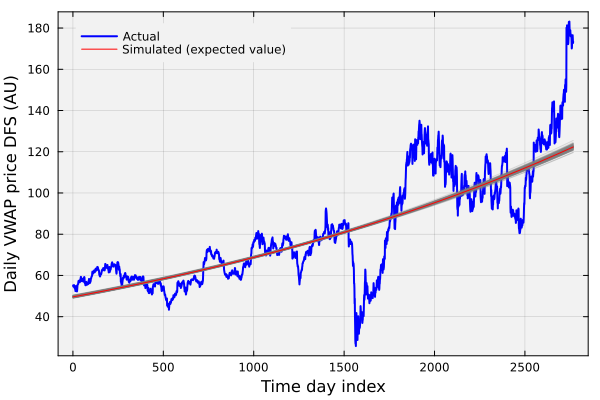

In [107]:
let

    N = 1000;
    θ = [
        θ̂_dictionary[rand_firm_ticker].b, # intercept
        θ̂_dictionary[rand_firm_ticker].m # slope
    ];


    Yₘ = A*θ;
    skip = 10;
    plot(exp.(Y),c=:blue,lw=2, label="Actual")
    mean_value = mean(exp.(error_simulation_array),dims=2);
    for i ∈ 1:skip:N
        Ŷ = error_simulation_array[:,i];
        plot!(exp.(Ŷ), c=:gray50, label="", alpha=0.25)
    end
    current()
    plot!(exp.(Yₘ),c=:red,lw=1, label="Simulated (expected value)")
    xlabel!("Time day index", fontsize=18);
    ylabel!("Daily VWAP price $(rand_firm_ticker) (AU)", fontsize=18)

    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
end

### Compute the uncertainty in the $\theta$ estimate
Let's compute the confidence intervals for the estimated model parameters $\hat{\mathbf{\theta}}$. To do this, we need to compute the standard errors of the parameter estimates $\mathrm{SE}(\hat{\mathbf{\theta}})$, which requires us to estimate the variance of the error terms $\hat{\sigma}^{2}$. 

Let's start there.

> __Theory:__ Since the __true__ variance $\sigma^2$ is unknown, we can estimate the population variance $\hat{\sigma}^2$ from the residuals $\mathbf{r} = \mathbf{y} - \hat{\mathbf{X}}\hat{\mathbf{\theta}}$ as:
> $$
\begin{align*}
\hat{\sigma}^{2} &= \frac{\lVert~\mathbf{r}~\rVert^{2}_{2}}{n-p} = \frac{1}{n-p}\sum_{i=1}^{n}r_i^2
\end{align*}
> $$
> where $n$ is the number of observations, $p$ is the number of parameters, $\lVert\star\rVert_{2}^{2}$ denotes the p = 2 norm squared, and $r_i = y_i - \hat{\mathbf{x}}_i^{\top}\hat{\mathbf{\theta}}$ is the $i$-th residual, i.e., the difference between the observed and predicted value for observation $i$.

We implement this computation in the code block below and save the result in the `training_variance::Float64` variable.

In [109]:
training_variance = let

    θ̂ = [
        θ̂_dictionary[rand_firm_ticker].b, # intercept
        θ̂_dictionary[rand_firm_ticker].m # slope
    ];


    # initialize -
    p = length(θ̂); # number of parameters
    n = size(A,1); # number of training observations

    # compute the residual -
    r = Y .- A*θ̂;

    # variance -
    my_variance = (1/(n-p))*norm(r)^2

    # let's compute the variance of the residuals (Julia)
    built_in_variance = var(r, corrected=true); # variance - Julia
    @show built_in_variance, my_variance; # show

    my_variance; # return
end;

(built_in_variance, my_variance) = (0.03847845516120577, 0.03849237141985356)


Next, let's compute the standard error. The standard error of the parameter estimates $\hat{\mathbf{\theta}}$ quantifies the uncertainty in the estimated parameters due to the variability in the data. Let's compute the standard error for each parameter $\hat{\theta}$ where we save the standard errors in the `SE::Vector{Float64}` variable, where element $j$ corresponds to the standard error of a parameter estimate $\text{SE}(\hat{\theta}_j)$.

In [111]:
SE = let


    θ̂ = [
        θ̂_dictionary[rand_firm_ticker].b, # intercept
        θ̂_dictionary[rand_firm_ticker].m # slope
    ];
    
    # initialize -
    p = length(θ̂); # number of parameters
    n = size(A,1); # number of training samples

    # compute the standard error -
    SE = sqrt.(diag(inv(transpose(A)*A))*training_variance);

    SE; # return
end;

Now that we have the standard error for each of the model parameters, we can compute the uncertainty in the parameter estimates $\hat{\mathbf{\theta}}$. Let's compute confidence intervals for each parameter estimate.
> __Confidence Intervals:__ A $(1-\alpha)\times{100}\%$ confidence interval for each parameter $\hat{\theta}_j$ is given by:
> $$
\begin{align*}
\hat{\theta}_j \pm t_{1-\alpha/2,\nu}\; \hat{\sigma}\; \sqrt{\bigl[(\hat{\mathbf X}^\top\hat{\mathbf X})^{-1}\bigr]_{jj}}
\end{align*}
$$
> where $t_{1-\alpha/2,\nu}$ is the $(1-\alpha/2)$-quantile of a Student $t$ distribution with $\nu$ degrees of freedom. For a 95% confidence interval, $\alpha = 0.05$ and $t_{1-\alpha/2,\nu} \approx 1.96$. For a 99.9% confidence interval, $\alpha = 0.001$ and $t_{1-\alpha/2,\nu} \approx 3.291$.

Let's build a table that shows the parameter ranges for a 95.0% confidence interval using [the `PrettyTables.jl` package](https://github.com/ronisbr/PrettyTables.jl). (You can adjust this to show another confidence interval if you like).

In [113]:
let

    θ̂ = [
        θ̂_dictionary[rand_firm_ticker].b, # intercept
        θ̂_dictionary[rand_firm_ticker].m # slope
    ];

    # initialize -
    t = 1.96; # for a 95% confidence interval
    df = DataFrame(); # hold the data (rows) for the table

    # build features of the table -
    feature_labels = Array{String,1}();
    push!(feature_labels, "intercept"); # add the intercept label
    push!(feature_labels, "slope"); # add the slope label

    for i ∈ eachindex(θ̂)

        center = θ̂[i];
        lower_bound = θ̂[i] - t*SE[i];
        upper_bound = θ̂[i] + t*SE[i];

        row_df = (
            i = i,
            feature = feature_labels[i],
            p = round(center, digits=4),
            l = round(lower_bound, digits=4),
            u = round(upper_bound, digits=4),
            cz = (lower_bound <= 0.0 <= upper_bound ? "yes" : "no")
        ) # data for the row

        push!(df, row_df) # add the row to the dataframe
    end

    # show the table -
    pretty_table(df, backend = :text,
        table_format = TextTableFormat(borders = text_table_borders__simple)) # new table API. Hmmm
end

======== =========== ========= ========= ========= =========
      i     feature         p         l         u       cz 
  Int64      String   Float64   Float64   Float64   String 
======== =========== ========= ========= ========= =========
      1   intercept    3.9044    3.8897     3.919       no
      2       slope    0.0822    0.0799    0.0845       no
======== =========== ========= ========= ========= =========


___

## Task 2: Estimate the volatility parameter $\sigma$ from data
In this task, we will estimate the volatility parameter $\sigma$ from historical data for all firms in the `dataset` $\mathcal{D}$. First, we will compute the log growth rates for the firms in the `list_of_tickers` $\mathcal{L}$ using the `log_return_matrix(...)` function.

[The `log_return_matrix(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.log_growth_matrix) takes `dataset` $\mathcal{D}$ and a list of firms $\mathcal{L}$ and computes the growth rate values for each firm as a function of time. The data is returned as a $\left(\dim\mathcal{D}_{i} - 1\right)\times\dim\mathcal{L}$ array (time on the rows, firms on the columns). 

We store the data in the `log_growth_array::Array{Float64,2}` variable:

In [116]:
log_growth_array = log_growth_matrix(dataset, list_of_tickers);

### Estimate the volatility parameter $\sigma$
Let's estimate the volatility parameter $\sigma$, i.e., the standard deviation of the return.
First, we define the `σ̂_dictionary::Dict{String, Float64}`, which will hold estimates of the annualized volatility parameters for each firm as `key`$\rightarrow$`value` pairs, where `key` is the `ticker` and the `value` is the annualized volatility value. 

For each firm $i$, we:
* Select a column from `log_growth_array`, get the corresponding `ticker` for firm $i$. We fit the return data to a `Normal` distribution `d` using [maximum likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation)
* We compute an estimate of the __annualized historical volatility__ as $\bar{\sigma}\cdot\sqrt{252}$ from the distribution `d`. We access the standard deviation of `d` using [the `params(...)` function from Distributions.jl](https://github.com/JuliaStats/Distributions.jl.git) package.

We save the annualized volatility estimate in the `σ̂_dictionary::Dict{String, Float64}` variable, where the key is the ticker symbol (String) and the value is the annualized volatility estimate.

In [118]:
σ̂_dictionary = let

    # initialize -
    σ̂_dictionary = Dict{String,Float64}();

    # process each firm in the list_of_tickers -
    for i ∈ eachindex(list_of_tickers)
        
        firm_ticker = list_of_tickers[i];
        firm_data = dataset[firm_ticker];
        samples = log_growth_array[:,i];
        R = samples.*Δt; # convert to time-adjusted returns
        d = fit_mle(Normal, R);
        σ̂_dictionary[firm_ticker] = params(d) |> last |> x-> *(x, sqrt(252)); # annualize
    end
    σ̂_dictionary; # return
end

Dict{String, Float64} with 424 entries:
  "EMR"  => 0.240223
  "CTAS" => 0.224176
  "HSIC" => 0.236052
  "KIM"  => 0.292348
  "PLD"  => 0.2202
  "IEX"  => 0.196286
  "BAC"  => 0.268653
  "CBOE" => 0.207348
  "EXR"  => 0.226075
  "NCLH" => 0.526415
  "CVS"  => 0.243123
  "DRI"  => 0.314924
  "DTE"  => 0.196927
  "ZION" => 0.346527
  "AVY"  => 0.227305
  "EW"   => 0.29425
  "EA"   => 0.253084
  "NWSA" => 0.263672
  "CAG"  => 0.245336
  "GILD" => 0.236486
  "FCX"  => 0.481084
  "GPC"  => 0.234789
  "UNP"  => 0.305612
  "CDW"  => 0.247662
  "SBUX" => 0.240358
  ⋮      => ⋮

### Save the data
Finally, let's save the estimated drift and volatility parameters to a file for later use. We will save the data in a CSV file named `SAGBM-Parameters-Fall-2025.csv` in the `data` directory.

In [120]:
parameters_df = let
    
    # initialize -
    parameters_df = DataFrame();
    t = 1.96; # for a 95% confidence interval

    # process each firm in the list_of_tickers -
    for i ∈ eachindex(list_of_tickers)
        
        firm_ticker = list_of_tickers[i];
        μ̂ = θ̂_dictionary[firm_ticker].m;
        σ̂ = σ̂_dictionary[firm_ticker];
        
        data_tuple = ( 
            ticker = firm_ticker,
            drift =  μ̂,
            t = t,
            lower_bound_drift = μ̂ - t*SE[2],
            upper_bound_drift = μ̂ + t*SE[2],
            volatility = σ̂
        );
        
        push!(parameters_df, data_tuple)
    end

    # save the data to a CSV file -
    CSV.write(joinpath(_PATH_TO_DATA,"SAGBM-Parameters-Fall-2025.csv"), parameters_df);

    parameters_df; # return
end

424×6 DataFrame
 Row │ ticker  drift        t        lower_bound_drift  upper_bound_drift  vol ⋯
     │ String  Float64      Float64  Float64            Float64            Flo ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ A        0.147468       1.96        0.145161            0.149774      0 ⋯
   2 │ AAL     -0.141294       1.96       -0.1436             -0.138988      0
   3 │ AAP     -0.0481021      1.96       -0.0504085          -0.0457958     0
   4 │ AAPL     0.24271        1.96        0.240403            0.245016      0
   5 │ ABBV     0.116          1.96        0.113693            0.118306      0 ⋯
   6 │ ABT      0.123083       1.96        0.120777            0.125389      0
   7 │ ACN      0.151012       1.96        0.148706            0.153319      0
   8 │ ADBE     0.224401       1.96        0.222094            0.226707      0
   9 │ ADI      0.146449       1.96        0.144142            0.148755      0 ⋯
  10 │ ADM      0.0564093      1.96        0.054103            0.0587156     0
  11 │ ADP      0.129221       1.96        0.126915            0.131527      0
  ⋮  │   ⋮          ⋮          ⋮             ⋮                  ⋮              ⋱
 415 │ WY       0.00305064     1.96        0.000744317         0.00535697    0
 416 │ WYNN    -0.0494769      1.96       -0.0517832          -0.0471705     0 ⋯
 417 │ XEL      0.0757171      1.96        0.0734108           0.0780235     0
 418 │ XOM      0.00632113     1.96        0.0040148           0.00862746    0
 419 │ XRAY    -0.0537881      1.96       -0.0560944          -0.0514818     0
 420 │ XYL      0.130132       1.96        0.127826            0.132438      0 ⋯
 421 │ YUM      0.0664123      1.96        0.064106            0.0687187     0
 422 │ ZBRA     0.189351       1.96        0.187044            0.191657      0
 423 │ ZION     0.0486871      1.96        0.0463808           0.0509934     0
 424 │ ZTS      0.184223       1.96        0.181916            0.186529      0 ⋯
                                                   1 column and 403 rows omitted

___

## Task 3: Visualize the simulation of a random firm for a random period
Now that we have the GBM parameter estimates for each firm in `dataset` $\mathcal{D}$, we can run simulations to see how the single asset GBM performs. Let's begin by selecting a random firm from our list of firms $\mathcal{L}$, get its price data, and store this in the `random_firm_data` variable:

In [123]:
random_firm_ticker = rand(list_of_tickers)
random_firm_data = dataset[random_firm_ticker];
println("The (randomly) selected firm in this study: $(random_firm_ticker)")

The (randomly) selected firm in this study: CVS


Next, randomly choose a contiguous time window of `T` days and analyze the model's performance during this period. To begin, randomly generate the `start_index` variable, i.e., the trading day index to start the simulation. The `stop_index` will then be determined by adding the number of trading days `T` to the `start_index`:

In [125]:
start_index = rand(1:(maximum_number_trading_days - T - 1))
stop_index = start_index + T
println("Visualize Firm-$(random_firm_ticker) between trading days ($(start_index) -> $(stop_index))")

Visualize Firm-CVS between trading days (2273 -> 2337)


Next, get the parameter values from the respective dictionaries for the randomly selected firm:

In [127]:
μ̂ = θ̂_dictionary[random_firm_ticker].m; # use the expected value of the slope
σ̂ = σ̂_dictionary[random_firm_ticker];
println("Firm-$(random_firm_ticker) has (μ̂,σ̂) = ($(μ̂),$(σ̂))")

Firm-CVS has (μ̂,σ̂) = (-0.019627238480754677,0.24312342966480793)


### Generate sample price trajectories for a GBM model
Create an instance of [the `MyGeometricBrownianMotionEquityModel` type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) using a custom [build function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyGeometricBrownianMotionEquityModel},%20NamedTuple}). 

We pass the kind of thing we want to build, i.e., [a `MyGeometricBrownianMotionEquityModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) to the [the `build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyGeometricBrownianMotionEquityModel},%20NamedTuple}), along with the growth and volatility parameters, and [the `build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyGeometricBrownianMotionEquityModel},%20NamedTuple}) returns the GBM model instance. 

We store the GBM model instance in the `model::MyGeometricBrownianMotionEquityModel` variable.

In [129]:
model = build(MyGeometricBrownianMotionEquityModel, (
            μ = μ̂, σ = σ̂ ));

Then, we solve the model between `T₁` and `T₂` starting with price `Sₒ` using [the `sample(…)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyGeometricBrownianMotionEquityModel,%20NamedTuple}) for `number_of_paths::Int64` sample paths. 

In [131]:
Sₒ = random_firm_data[start_index,:volume_weighted_average_price];
T₁ = start_index*Δt
T₂ = stop_index*Δt

# generate sample paths using the GBM model
X = VLQuantitativeFinancePackage.sample(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt), 
    number_of_paths = 100);

In addition to the numerical samples, we have analytical expressions for both the expected value and the variance of the share price. We've implemented the analytical expectation and variance calculations in the `expectation(...)` and `variance(...)` functions. Let's call these functions to get analytical values for the expectation and variance of the VWAP.

In [133]:
expectation_array = expectation(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt));
variance_array = variance(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt));

`Unhide` the block below to see how to plot the expected value and the variance of the simulated share price versus the actual share price, as well as the sampled trajectories.

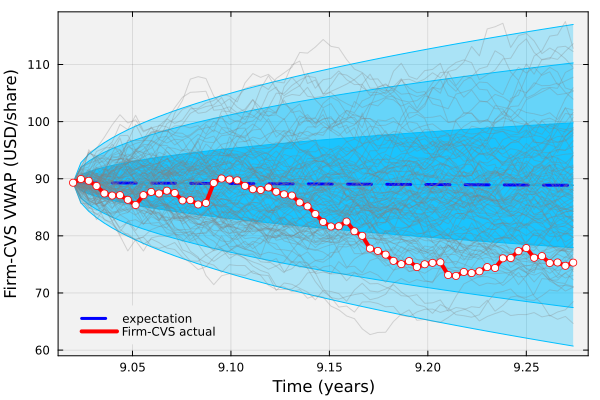

In [135]:
let
    
    # Initialize -
    L68 = expectation_array[:,2] .- sqrt.(variance_array[:,2])
    U68 = expectation_array[:,2] .+ sqrt.(variance_array[:,2])
    L95 = expectation_array[:,2] .- 1.96*sqrt.(variance_array[:,2])
    U95 = expectation_array[:,2] .+ 1.96*sqrt.(variance_array[:,2])
    L99 = expectation_array[:,2] .- 2.576*sqrt.(variance_array[:,2])
    U99 = expectation_array[:,2] .+ 2.576*sqrt.(variance_array[:,2])

    plot(expectation_array[:,1], expectation_array[:,2], fillrange=L68, c=:deepskyblue1, alpha=0.75, label="")
    plot!(expectation_array[:,1], expectation_array[:,2], fillrange=U68, c=:deepskyblue1, alpha=0.75, label="")
    plot!(expectation_array[:,1], expectation_array[:,2], fillrange=L95, c=:deepskyblue1, alpha=0.4, label="")
    plot!(expectation_array[:,1], expectation_array[:,2], fillrange=U95, c=:deepskyblue1, alpha=0.4, label="")
    plot!(expectation_array[:,1], expectation_array[:,2], fillrange=L99, c=:deepskyblue1, alpha=0.3, label="")
    plot!(expectation_array[:,1], expectation_array[:,2], fillrange=U99, c=:deepskyblue1, alpha=0.3, label="")

    plot!(expectation_array[:,1], expectation_array[:,2],c=:blue, lw=3,ls=:dash, label="expectation")
    plot!(expectation_array[:,1], L68, c=:deepskyblue1, lw=1, label="")
    plot!(expectation_array[:,1], U68, c=:deepskyblue1, lw=1, label="")
    plot!(expectation_array[:,1], L95, c=:deepskyblue1, lw=1, label="")
    plot!(expectation_array[:,1], U95, c=:deepskyblue1, lw=1, label="")
    plot!(expectation_array[:,1], L99, c=:deepskyblue1, lw=1, label="")
    plot!(expectation_array[:,1], U99, c=:deepskyblue1, lw=1, label="")
    plot!(X[:,1],X[:,2:end], label="", c=:gray, alpha=0.3)
    plot!(X[:,1], random_firm_data[start_index:stop_index, :volume_weighted_average_price], lw=4, c=:red, 
        label="Firm-$(random_firm_ticker) actual")
     scatter!(X[1:end,1], random_firm_data[start_index:stop_index, :volume_weighted_average_price], label="", 
         msc=:red, mc=:white)


    xlabel!("Time (years)", fontsize=18)
    ylabel!("Firm-$(random_firm_ticker) VWAP (USD/share)", fontsize=18)

    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
end

#### Check: Was this a successful GBM simulation?
Determining whether a model accurately represents data can be done in various ways, but we will utilize a simple, straightforward functional test. 

> __Functional test__
> 
> * __Success__: If the simulated price falls within a specified lower bound ($L_{j}$) and upper bound ($U_{j}$) for all times $t_j$ within a given interval ($t_{j}\in\mathcal{I}_{k}$), then the model is deemed a `success.`
> * __Failure__: However, if the actual price exceeds the given bounds __at any point__, the simulation is considered a `failure.`

So, did we succeed or fail (for this ticker and time period)?

In [137]:
let
    z = 2.576;
    L = expectation_array[:,2] .- z*sqrt.(variance_array[:,2])
    U = expectation_array[:,2] .+ z*sqrt.(variance_array[:,2])
       
    # check the bounds: if below L, or above U then the simulation failed
    success_flag = true;
    for k ∈ 1:T
        if (random_firm_data[start_index+k-1,:volume_weighted_average_price] < L[k]) || (random_firm_data[start_index+k-1,:volume_weighted_average_price] > U[k])
            success_flag = false;
            break;
        end
    end
    
    println("The simulation of the VWAP of Firm-$(random_firm_ticker) between ($(start_index) -> $(stop_index)) was successful: $(success_flag)")
end

The simulation of the VWAP of Firm-CVS between (2273 -> 2337) was successful: true


## Summary
In this example, we estimated GBM parameters from historical S&P500 data and validated the model through statistical testing and simulation comparison with real market data.

> __Key Takeaways__
> * **Linear regression and maximum likelihood methods provide robust parameter estimation.** We successfully estimated drift parameters using linear regression on log prices and volatility parameters through maximum likelihood fitting, demonstrating how statistical methods can extract model parameters from real market data.
>
> * **Statistical validation reveals model assumptions and limitations.** Through Anderson-Darling testing and residual analysis, we assessed the normality assumption and quantified uncertainty in parameter estimates using confidence intervals, highlighting the importance of validating model assumptions.
>
> * **GBM simulations capture central price trends but show predictable limitations.** Our simulation comparisons demonstrated that GBM models can track expected price behavior and provide reasonable uncertainty bounds, while also revealing the model's inability to capture all market dynamics and extreme events.

___

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.